#Spectral Plotting
In this notebook we will expand upon the basic spectral plot in the last notebook.  We will use the Kaguya spectral profiler dataset to be able to illustrate a few more helpful functions from NumPy and SciPy.

In [1]:
%pylab inline
import sp_extract as spe

Populating the interactive namespace from numpy and matplotlib


A spectral profiler image is composed of four files:

1. A thumbnail browse image (.jpg)
2. A full size image (P.jpg)
3. A pseudo world file (.ctg)
4. A data file (.spc)

<matplotlib.colorbar.Colorbar instance at 0x108369ab8>

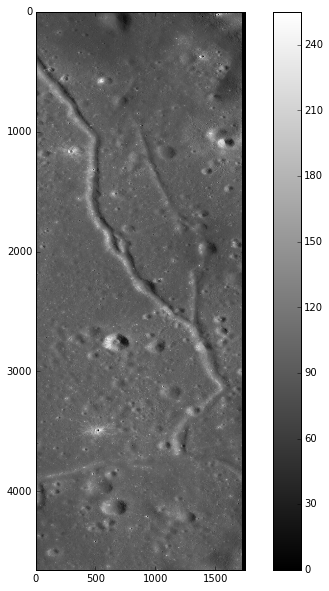

In [2]:
figsize(10,10)
browse_image = imread('data/SP_2C_02_07441_S136_E3584P.jpg')
imshow(browse_image, cmap='gray')
colorbar()

The binary format that the data is stored is non-trivial to parse.  We provide a module, sp_extract that is able to open the data and extract the spectra.

In [3]:
extracted = spe.openspc('data/SP_2C_02_07441_S136_E3584.spc')
wv_array, rad_array, ref_array, angles, qa_array, ullat, lllat = extracted

First, we should get the lay of the land.  How many spot spectra have we extracted?  What are all of these returned values?

In [4]:
print('Wavelength Shape: ', wv_array.shape)
print('Radiance Shape: ', rad_array.shape)
print('Quality Assurance Shape: ', qa_array.shape)
print('Angles Shape: ', angles.shape)
print(ullat, lllat)

('Wavelength Shape: ', (296,))
('Radiance Shape: ', (83, 296))
('Quality Assurance Shape: ', (83, 296))
('Angles Shape: ', (83, 3))
(-12.829278, -14.397875)


So we see consistency in shape (which is a good thing).  The data products contains 83 individual spot readings covering 296 channels.

Unfortunately, the data is still not ready for analysis.  It is extremely noisy at higher wavelengths and we see overlapping, conflicting, observations around 1000nm.

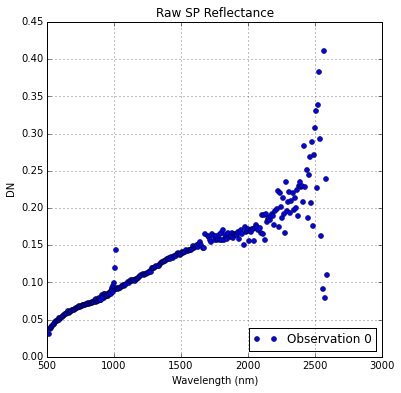

In [5]:
figsize(6,6)
plot(wv_array, ref_array[0], 'o', label='Observation 0', markersize=5)
xlabel('Wavelength (nm)')
ylabel('DN')
title('Raw SP Reflectance')
legend(loc=4)
grid()

Lets clean the data first using the team provided QA array.

In [6]:
def cleandata(qa_array, wv_array, ref_array):
    """
    Clean a series of SP spot observations using a QA array.
    
    Parameters
    ----------
    qa_array : array
               (m,n) the Quality Assurance array
    wv_array : array
               (n, ) a vector of wavelengths
    ref_array : array
                (m,n) an array of reflectance values
                
    Returns
    --------
    masked_wv : array
                (n,) a vector of wavelengths with 'bad' values masked
    
    masked_ref : array
                 (m, n) a relfectance array with 'bad' values masked
    """
    masked_wv = wv_array[qa_array[0] < 2000]
    mask_size = len(masked_wv)
    masked_ref = np.empty((ref_array.shape[0], mask_size), dtype=np.float64)
    
    for i, v in enumerate(ref_array):
        masked_ref[i] = v[qa_array[0] < 2000]
    
    return masked_wv, masked_ref
    
masked_wv, masked_ref = cleandata(qa_array, wv_array, ref_array)

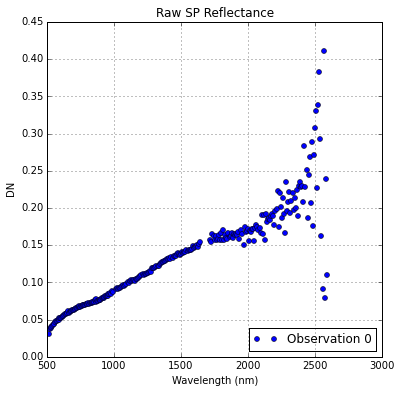

In [7]:
figsize(6,6)
plot(masked_wv, masked_ref[0], 'o', label='Observation 0', markersize=5)
xlabel('Wavelength (nm)')
ylabel('DN')
title('Raw SP Reflectance')
legend(loc=4)
grid()

We have successfully cleaned the overlapping data out using the quality assurance array.  The QA arrays pops a few additional wavelengths as well; these are defined by the SP team.

If you want to see what the QA array looks like, go ahead and print it.  I would add the [0] index to only see the QA array for the first observations.  In our experience the QA array is always the same for all observations within a since data product.

Next, we probably want to visualize the approximate location of each observation on the browse image.  We make a few (huge) assumptions here:

1. The observations bisect the browse image.
2. The observations are evenly spaced.

In [8]:
nrows, ncols = browse_image.shape
nobs = masked_ref.shape[0]
#Don't forget the spe.observation_list? syntax to get the docs string
x, y, pt_to_obs = spe.observation_list(nrows, ncols, nobs)

###Browse image with spot observations

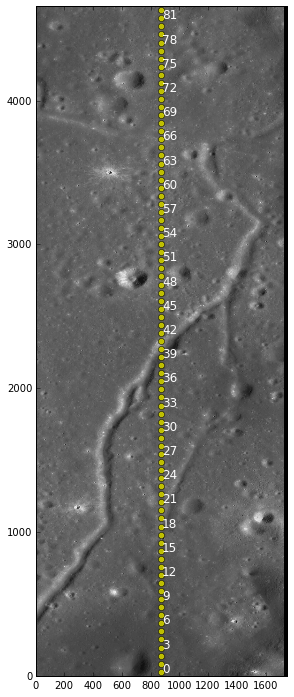

In [9]:
#Explicitly create a figure with a single subplot
figsize(12,12)
fig = figure()
ax = fig.add_subplot(111, autoscale_on=False,
                     xlim=(0, browse_image.shape[1]),
                     ylim=(0,browse_image.shape[0]))

#Plot the image and the spot observations
ax.imshow(browse_image, cmap='gray')
ax.plot(x, y, 'yo')

#Add point labels so we know the index to observation mapping viusally
for i, xy in enumerate(zip(x, y)):
    if i % 3 == 0:
        ax.annotate('{}'.format(i), xy=(xy[0] + 10, xy[1]), color='white', fontsize=12)

#An explicit call to show if required because of how the figure was created
show()

I am going to guess that observation 40 might be interesting to visualize.  I would encourage you to pick another one if you like.

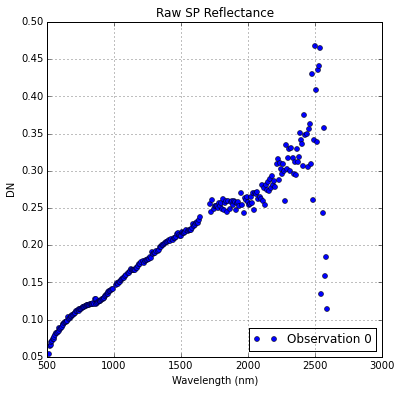

In [10]:
figsize(6,6)
plot(masked_wv, masked_ref[40], 'o', label='Observation 0', markersize=5)
xlabel('Wavelength (nm)')
ylabel('DN')
title('Raw SP Reflectance')
legend(loc=4)
grid()

It is pretty hard to tell what is going on becuase we need to remove the continuum.  Before we removed the continuum with a two part linear fit.  The SP team uses OLS regression.  We could definitely use the linear fit from the previous notebook if desired.

In [11]:
#Lets use someone else linear regression so we do not have to write our own.
import scipy.stats as ss

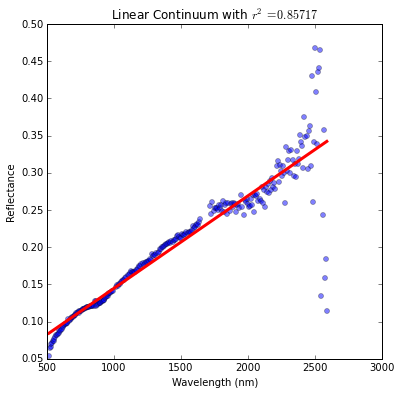

In [12]:
obs40 = masked_ref[40]
wv = masked_wv
slope, intercept, r_value, p_value, stderr = ss.linregress(wv, obs40)
continuum = slope * wv + intercept
plot(wv, obs40, 'bo', alpha=0.5, markersize=5)
plot(wv, continuum, 'r-', linewidth=3)
xlabel('Wavelength (nm)')
ylabel('Reflectance')
title('Linear Continuum with $r^2 = {}$'.format(round(r_value**2, 5)))


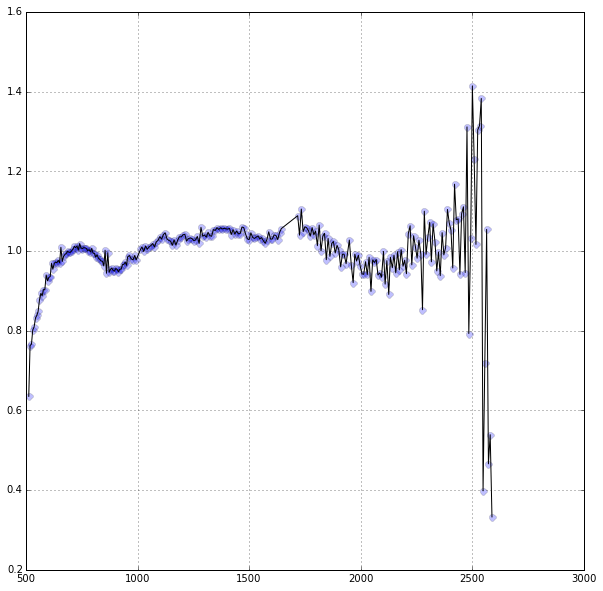

In [13]:
figsize(10,10)
corrected40 = obs40 / continuum
plot(wv, obs40 / continuum, 'bo', alpha=0.25, markersize=7)
plot(wv, corrected40, 'k-')
grid()

The data is exceptionally noisy.  We can do two things to clean the data further:
 
1. Smooth the data.
2. Clip to just past the 2000nm band center

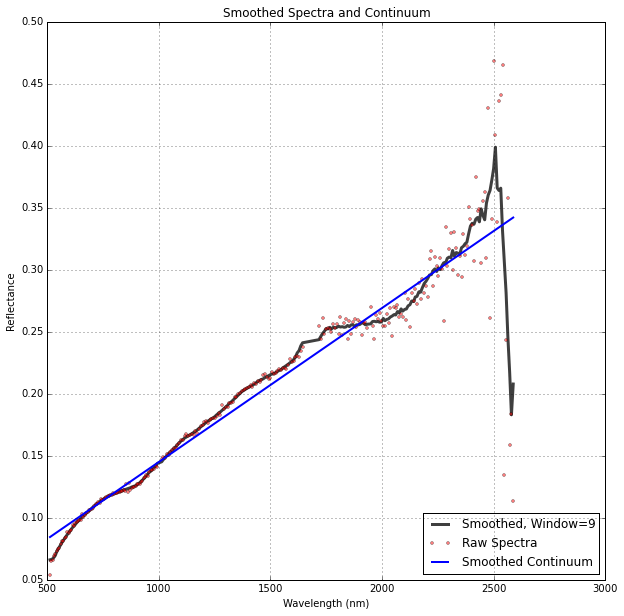

In [38]:
#Smooth the full range of the data
window = 9
windowclip, _ = divmod(window,2)

smooth40 = spe.smooth(obs40, window_len=window, window='flat')

#The smooth method uses reflection at the ends of the window that must be clipped.
plot(wv, smooth40[windowclip:-windowclip], 'k-',
     label='Smoothed, Window={}'.format(window),
     alpha=0.75, linewidth=3)
plot(wv, obs40, 'ro', alpha=0.5, label='Raw Spectra',markersize=3)

#Now compute the continuum using the smoothed spectra
slope, intercept, r_value, p_value, stderr = ss.linregress(wv, 
                                                           smooth40[windowclip:-windowclip])
smoothed_continuum = slope * wv + intercept

#Plot the continuum
plot(wv, smoothed_continuum, 'b-', linewidth=2, label='Smoothed Continuum')

#Plot nicities
grid()
legend(loc=4)
xlabel('Wavelength (nm)')
ylabel('Reflectance')
title('Smoothed Spectra and Continuum')

Now we will clip the data just just past the 2000nm band center.

In [47]:
#Create a boolean mask of all wavelengths below 2250nm
mask = wv < 2250
print wv[mask][-5:]  #Just the end of the spectra

[ 2213.   2221.2  2228.7  2236.8  2245. ]


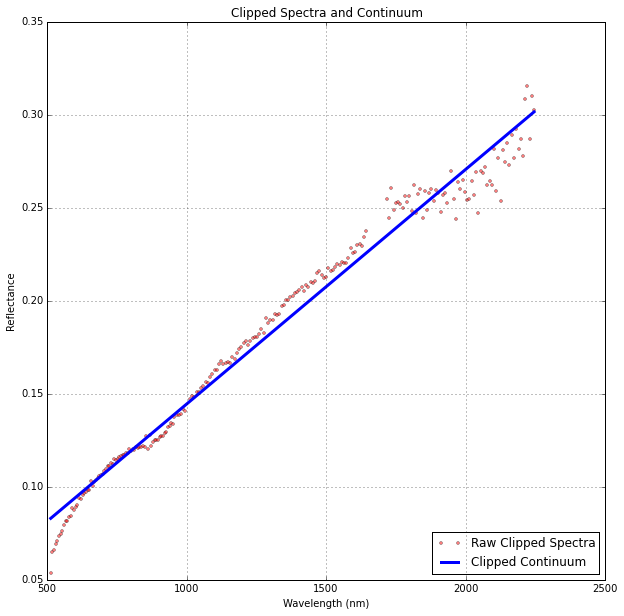

In [49]:
#Compute the continuum from the clipped data
slope, intercept, r_value, p_value, stderr = ss.linregress(wv[mask], 
                                                           obs40[mask])
clipped_continuum = slope * wv[mask] + intercept

plot(wv[mask], obs40[mask], 'ro', markersize=3, alpha=0.5, label='Raw Clipped Spectra')
plot(wv[mask], clipped_continuum, label='Clipped Continuum', linewidth=3)

#Plot nicities
grid()
legend(loc=4)
xlabel('Wavelength (nm)')
ylabel('Reflectance')
title('Clipped Spectra and Continuum')

Lets finish this section working with the clipped OLS continuum and smoothing after continuum correction.

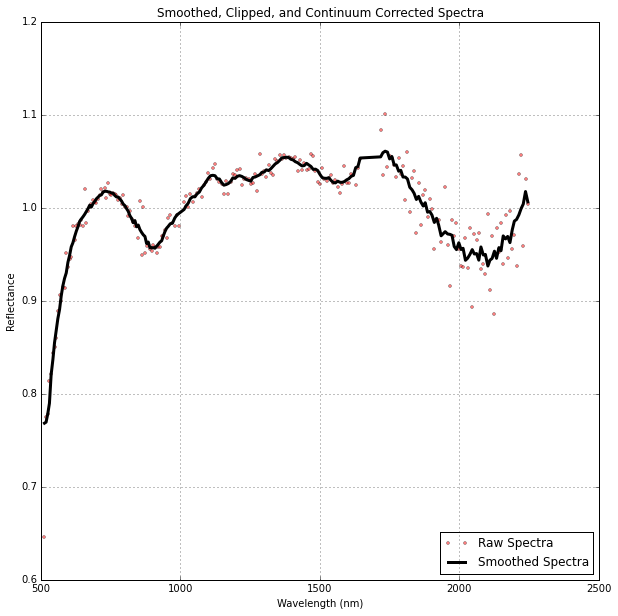

In [58]:
mask40 = obs40[mask]
mwv = wv[mask]
plot(mwv, mask40 / clipped_continuum, 'ro', label='Raw Spectra', markersize=3, alpha=0.5)

smooth_mask40 = spe.smooth(mask40 / clipped_continuum, window_len=7, window='flat')[3:-3]
plot(mwv, smooth_mask40, 'k-', linewidth=3, label='Smoothed Spectra')

#Plot nicities
grid()
legend(loc=4)
xlabel('Wavelength (nm)')
ylabel('Reflectance')
title('Smoothed, Clipped, and Continuum Corrected Spectra')

##Hands on
It would be easier if we could write a function that could take an observation ID and return a plot.  Even better would be to return the contents of a plot, but lets stick with the simpler task - parameters in - plot shown.

In [ ]:
def plot_sp_id(observationid, wv, masked_ref, smooth=True):
    """
    Write some documentation
    
    Parameters
    ----------
    observationid : int
                    The ID of the spectra to visualize
    wv : array
         The wavelength vector
         
    masked_ref : array
                 The raw, cleaned reflectance array
    
    smooth : boolean
             Default True, smooth the spectra for visualization
                    
    """
    
    #Extract the spectra from the masked_ref array
    raw_spectra = masked_ref[observationid]
    
    #Clip the array to 2250
    mask = wv < ???
    mwv = wv[mask]
    clipped_spectra = raw_spectra[???]
    
    #Compute the clipped continuum
    slope, intercept, r_value, p_value, stderr = ss.linregress(mwv, 
                                                           ???)
    clipped_continuum = slope * wv[mask] + intercept

    #Plot the raw continuum corrected spectra
    plot(x???, y???, style???, label=???, markersize=???, alpha=???)

    #Smooth the spectra
    smooth_mask40 = spe.smooth(mask40 / clipped_continuum, window_len=7, window='flat')[3:-3]
    plot(mwv, smooth_mask40, 'k-', linewidth=3, label='Smoothed Spectra')
    
    #Maybe some plot nicities?
    
    show()
    
plot_sp_id(0, wv, masked_ref, smooth=True)

##A solution is below...

In [74]:
def plot_sp_id(observationid, wv, masked_ref, smooth=True):
    """
    Write some documentation
    
    Parameters
    ----------
    observationid : int
                    The ID of the spectra to visualize
    wv : array
         The wavelength vector
         
    masked_ref : array
                 The raw, cleaned reflectance array
    
    smooth : boolean
             Default True, smooth the spectra for visualization
                    
    """
    
    #Extract the spectra from the masked_ref array
    raw_spectra = masked_ref[observationid]
    
    #Clip the array to 2250
    mask = wv < 2250
    mwv = wv[mask]
    clipped_spectra = raw_spectra[mask]
    
    #Compute the clipped continuum
    slope, intercept, r_value, p_value, stderr = ss.linregress(mwv, 
                                                           clipped_spectra)
    clipped_continuum = slope * wv[mask] + intercept

    #Plot the raw continuum corrected spectra
    plot(mwv, mask40 / clipped_continuum, 'ro', label='Raw Spectra', markersize=3, alpha=0.5)

    smooth_mask40 = spe.smooth(mask40 / clipped_continuum, window_len=7, window='flat')[3:-3]
    plot(mwv, smooth_mask40, 'k-', linewidth=3, label='Smoothed Spectra')


    
    #Maybe some plot nicities?
    
    show()
    
plot_sp_id(0, wv, masked_ref, smooth=True)